In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.001
num_episodes = 10000
gamma=0.9999
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=500000

batch_size=32

update_target_frequency = 1500

clip_error=False

double_dqn=True

In [9]:
env = gym.make('CartPole-v1')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
o=torch.arange(20,dtype=torch.float32).view(-1,4).contiguous()

In [14]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [15]:
class NeuralNetworkDueling(nn.Module):
    def __init__(self):
        super(NeuralNetworkDueling, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.advantage = nn.Linear(hidden_layer_size,number_of_outputs)
        self.value = nn.Linear(hidden_layer_size,1)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        
        #print('x shape {} and value:'.format(x.shape))
        #print(x.detach().cpu())
        
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        
        #print('output1 shape {} and value:'.format(output1.shape))
        #print(output1.detach().cpu())
        
        output_advantage=self.advantage(output1)
        output_value=self.value(output1)
        
        #print('output_advantage shape {} and value:'.format(output_advantage.shape))
        #print(output_advantage.detach().cpu())
        
        #print('output_value shape {} and value:'.format(output_value.shape))
        #print(output_value.detach().cpu())
        
        #print('output_advantage.mean shape {} and value:'.format(output_advantage.mean(dim=1,keepdim=True).shape))
        #print(output_advantage.mean(dim=1,keepdim=True).detach().cpu())
        
        output_final=output_value+output_advantage-output_advantage.mean(dim=1,keepdim=True)
        
        
        return output_final

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [17]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetworkDueling().to(device)
        self.target_nn = NeuralNetworkDueling().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state.unsqueeze(dim=0)).squeeze()
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
            
        if double_dqn:
            #print('in double DQN')
            new_state_values_from_nn=self.nn(new_state).detach()
            #print('new_state_values_from_nn shape {} and value:'.format(new_state_values_from_nn.shape))
            #print(new_state_values_from_nn)
            max_new_state_indexes=torch.max(new_state_values_from_nn,dim=1)[1].view(-1,1)
            #print('max_new_state_indexes shape {} and value:'.format(max_new_state_indexes.shape))
            #print(max_new_state_indexes)
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value:'.format(new_state_values.shape))
            #print(new_state_values)
            max_new_state_values=torch.gather(new_state_values,1,max_new_state_indexes).squeeze()
            #print('max_new_state_values shape {} and value:'.format(max_new_state_values.shape))
            #print(max_new_state_values)
        else:
            #print('in regular DQN')
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value'.format(new_state_values.shape))
            #print(new_state_values)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('max_new_state_values shape {} and value'.format(max_new_state_values.shape))
            #print(max_new_state_values)
            
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [18]:
memory=ExperienceReplay(replay_memory_size)

In [19]:
qnet_agent=QNet_Agent()

In [20]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [21]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 19.7
Average over all episodes so far: 19.7
epsilon: 0.5994686056863888
**** Episode  20 **** 
Recent average reward: 13.9
Average over all episodes so far: 16.8
epsilon: 0.4440767938169008
**** Episode  30 **** 
Recent average reward: 13.3
Average over all episodes so far: 15.633333333333333
epsilon: 0.34941429240982874
**** Episode  40 **** 
Recent average reward: 10.3
Average over all episodes so far: 14.3
epsilon: 0.288445253217132
**** Episode  50 **** 
Recent average reward: 12.0
Average over all episodes so far: 13.84
epsilon: 0.2246956540525452
**** Episode  60 **** 
Recent average reward: 11.7
Average over all episodes so far: 13.483333333333333
epsilon: 0.1836812048494591
**** Episode  70 **** 
Recent average reward: 9.7
Average over all episodes so far: 12.942857142857143
epsilon: 0.1524828245151523
**** Episode  80 **** 
Recent average reward: 10.5
Average over all episodes so far: 12.6375
epsilon: 0.12480344162250226
**** Episo

**** Episode  550 **** 
Recent average reward: 9.5
Reward over last 100: 9.75
Average over all episodes so far: 10.747272727272728
epsilon: 0.010006404345483179
**** Episode  560 **** 
Recent average reward: 9.1
Reward over last 100: 9.71
Average over all episodes so far: 10.717857142857143
epsilon: 0.01000532800430753
**** Episode  570 **** 
Recent average reward: 9.8
Reward over last 100: 9.57
Average over all episodes so far: 10.701754385964913
epsilon: 0.010004397238550358
**** Episode  580 **** 
Recent average reward: 12.2
Reward over last 100: 9.81
Average over all episodes so far: 10.727586206896552
epsilon: 0.010003431428825739
**** Episode  590 **** 
Recent average reward: 12.1
Reward over last 100: 10.02
Average over all episodes so far: 10.750847457627119
epsilon: 0.010002699257517593
**** Episode  600 **** 
Recent average reward: 11.2
Reward over last 100: 10.18
Average over all episodes so far: 10.758333333333333
epsilon: 0.010002148944393299
**** Episode  610 **** 
Recent

**** Episode  1090 **** 
Recent average reward: 222.0
Reward over last 100: 221.88
Average over all episodes so far: 93.0137614678899
epsilon: 0.01
**** Episode  1100 **** 
Recent average reward: 219.3
Reward over last 100: 219.67
Average over all episodes so far: 94.16181818181818
epsilon: 0.01
**** Episode  1110 **** 
Recent average reward: 223.6
Reward over last 100: 221.34
Average over all episodes so far: 95.32792792792793
epsilon: 0.01
**** Episode  1120 **** 
Recent average reward: 217.3
Reward over last 100: 221.8
Average over all episodes so far: 96.41696428571429
epsilon: 0.01
**** Episode  1130 **** 
Recent average reward: 237.3
Reward over last 100: 224.43
Average over all episodes so far: 97.66371681415929
epsilon: 0.01
**** Episode  1140 **** 
Recent average reward: 252.9
Reward over last 100: 225.73
Average over all episodes so far: 99.02543859649123
epsilon: 0.01
**** Episode  1150 **** 
Recent average reward: 249.6
Reward over last 100: 228.42
Average over all episodes

**** Episode  1650 **** 
Recent average reward: 277.2
Reward over last 100: 260.05
Average over all episodes so far: 144.37878787878788
epsilon: 0.01
**** Episode  1660 **** 
Recent average reward: 274.6
Reward over last 100: 262.75
Average over all episodes so far: 145.1632530120482
epsilon: 0.01
**** Episode  1670 **** 
Recent average reward: 274.2
Reward over last 100: 265.86
Average over all episodes so far: 145.93592814371257
epsilon: 0.01
**** Episode  1680 **** 
Recent average reward: 240.5
Reward over last 100: 265.82
Average over all episodes so far: 146.4988095238095
epsilon: 0.01
**** Episode  1690 **** 
Recent average reward: 281.1
Reward over last 100: 272.33
Average over all episodes so far: 147.29526627218934
epsilon: 0.01
**** Episode  1700 **** 
Recent average reward: 347.1
Reward over last 100: 274.89
Average over all episodes so far: 148.47058823529412
epsilon: 0.01
**** Episode  1710 **** 
Recent average reward: 321.4
Reward over last 100: 284.77
Average over all ep

**** Episode  2200 **** 
Recent average reward: 358.3
Reward over last 100: 435.0
Average over all episodes so far: 191.82090909090908
epsilon: 0.01
**** Episode  2210 **** 
Recent average reward: 476.8
Reward over last 100: 435.64
Average over all episodes so far: 193.110407239819
epsilon: 0.01
**** Episode  2220 **** 
Recent average reward: 473.5
Reward over last 100: 442.94
Average over all episodes so far: 194.37342342342342
epsilon: 0.01
**** Episode  2230 **** 
Recent average reward: 500.0
Reward over last 100: 446.71
Average over all episodes so far: 195.7439461883408
epsilon: 0.01
**** Episode  2240 **** 
Recent average reward: 468.2
Reward over last 100: 448.82
Average over all episodes so far: 196.96026785714287
epsilon: 0.01
**** Episode  2250 **** 
Recent average reward: 472.7
Reward over last 100: 453.19
Average over all episodes so far: 198.1857777777778
epsilon: 0.01
**** Episode  2260 **** 
Recent average reward: 500.0
Reward over last 100: 457.43
Average over all episo

**** Episode  2760 **** 
Recent average reward: 398.7
Reward over last 100: 486.85
Average over all episodes so far: 253.37101449275363
epsilon: 0.01
**** Episode  2770 **** 
Recent average reward: 400.1
Reward over last 100: 476.86
Average over all episodes so far: 253.90072202166064
epsilon: 0.01
**** Episode  2780 **** 
Recent average reward: 351.5
Reward over last 100: 462.01
Average over all episodes so far: 254.25179856115108
epsilon: 0.01
**** Episode  2790 **** 
Recent average reward: 399.9
Reward over last 100: 452.0
Average over all episodes so far: 254.77383512544802
epsilon: 0.01
**** Episode  2800 **** 
Recent average reward: 354.7
Reward over last 100: 437.47
Average over all episodes so far: 255.13071428571428
epsilon: 0.01
**** Episode  2810 **** 
Recent average reward: 312.9
Reward over last 100: 418.76
Average over all episodes so far: 255.33629893238435
epsilon: 0.01
**** Episode  2820 **** 
Recent average reward: 121.7
Reward over last 100: 380.93
Average over all e

**** Episode  3320 **** 
Recent average reward: 500.0
Reward over last 100: 497.75
Average over all episodes so far: 270.79006024096384
epsilon: 0.01
**** Episode  3330 **** 
Recent average reward: 500.0
Reward over last 100: 497.75
Average over all episodes so far: 271.47837837837835
epsilon: 0.01
**** Episode  3340 **** 
Recent average reward: 500.0
Reward over last 100: 497.75
Average over all episodes so far: 272.1625748502994
epsilon: 0.01
**** Episode  3350 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 272.84268656716415
epsilon: 0.01
**** Episode  3360 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 273.51875
epsilon: 0.01
**** Episode  3370 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 274.19080118694365
epsilon: 0.01
**** Episode  3380 **** 
Recent average reward: 477.4
Reward over last 100: 497.74
Average over all episodes so f

**** Episode  3880 **** 
Recent average reward: 500.0
Reward over last 100: 497.85
Average over all episodes so far: 303.7257731958763
epsilon: 0.01
**** Episode  3890 **** 
Recent average reward: 500.0
Reward over last 100: 497.85
Average over all episodes so far: 304.23033419023136
epsilon: 0.01
**** Episode  3900 **** 
Recent average reward: 500.0
Reward over last 100: 497.85
Average over all episodes so far: 304.7323076923077
epsilon: 0.01
**** Episode  3910 **** 
Recent average reward: 500.0
Reward over last 100: 497.85
Average over all episodes so far: 305.2317135549872
epsilon: 0.01
**** Episode  3920 **** 
Recent average reward: 500.0
Reward over last 100: 497.85
Average over all episodes so far: 305.72857142857146
epsilon: 0.01
**** Episode  3930 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 306.2229007633588
epsilon: 0.01
**** Episode  3940 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episod

**** Episode  4440 **** 
Recent average reward: 481.0
Reward over last 100: 480.6
Average over all episodes so far: 327.96463963963964
epsilon: 0.01
**** Episode  4450 **** 
Recent average reward: 480.2
Reward over last 100: 478.62
Average over all episodes so far: 328.3067415730337
epsilon: 0.01
**** Episode  4460 **** 
Recent average reward: 484.3
Reward over last 100: 479.33
Average over all episodes so far: 328.65650224215244
epsilon: 0.01
**** Episode  4470 **** 
Recent average reward: 500.0
Reward over last 100: 479.33
Average over all episodes so far: 329.03982102908276
epsilon: 0.01
**** Episode  4480 **** 
Recent average reward: 492.0
Reward over last 100: 478.77
Average over all episodes so far: 329.4035714285714
epsilon: 0.01
**** Episode  4490 **** 
Recent average reward: 500.0
Reward over last 100: 478.77
Average over all episodes so far: 329.7835189309577
epsilon: 0.01
**** Episode  4500 **** 
Recent average reward: 500.0
Reward over last 100: 480.6
Average over all episo

**** Episode  5000 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 346.3218
epsilon: 0.01
**** Episode  5010 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 346.62854291417165
epsilon: 0.01
**** Episode  5020 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 346.9340637450199
epsilon: 0.01
**** Episode  5030 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 347.23836978131214
epsilon: 0.01
**** Episode  5040 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 347.5414682539683
epsilon: 0.01
**** Episode  5050 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 347.84336633663366
epsilon: 0.01
**** Episode  5060 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 34

**** Episode  5560 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 361.8001798561151
epsilon: 0.01
**** Episode  5570 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 362.0482944344704
epsilon: 0.01
**** Episode  5580 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 362.2955197132616
epsilon: 0.01
**** Episode  5590 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 362.54186046511626
epsilon: 0.01
**** Episode  5600 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 362.78732142857143
epsilon: 0.01
**** Episode  5610 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 363.0319073083779
epsilon: 0.01
**** Episode  5620 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so

**** Episode  6120 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 374.44591503267975
epsilon: 0.01
**** Episode  6130 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 374.65073409461667
epsilon: 0.01
**** Episode  6140 **** 
Recent average reward: 429.2
Reward over last 100: 492.92
Average over all episodes so far: 374.73957654723125
epsilon: 0.01
**** Episode  6150 **** 
Recent average reward: 301.4
Reward over last 100: 473.06
Average over all episodes so far: 374.62032520325204
epsilon: 0.01
**** Episode  6160 **** 
Recent average reward: 89.0
Reward over last 100: 431.96
Average over all episodes so far: 374.15665584415586
epsilon: 0.01
**** Episode  6170 **** 
Recent average reward: 57.0
Reward over last 100: 387.66
Average over all episodes so far: 373.64262560777956
epsilon: 0.01
**** Episode  6180 **** 
Recent average reward: 67.3
Reward over last 100: 344.39
Average over all episo

**** Episode  6680 **** 
Recent average reward: 473.7
Reward over last 100: 386.38
Average over all episodes so far: 379.33203592814374
epsilon: 0.01
**** Episode  6690 **** 
Recent average reward: 500.0
Reward over last 100: 386.38
Average over all episodes so far: 379.5124065769806
epsilon: 0.01
**** Episode  6700 **** 
Recent average reward: 500.0
Reward over last 100: 386.57
Average over all episodes so far: 379.69223880597013
epsilon: 0.01
**** Episode  6710 **** 
Recent average reward: 500.0
Reward over last 100: 398.21
Average over all episodes so far: 379.8715350223547
epsilon: 0.01
**** Episode  6720 **** 
Recent average reward: 500.0
Reward over last 100: 413.55
Average over all episodes so far: 380.0502976190476
epsilon: 0.01
**** Episode  6730 **** 
Recent average reward: 500.0
Reward over last 100: 442.07
Average over all episodes so far: 380.22852897473996
epsilon: 0.01
**** Episode  6740 **** 
Recent average reward: 500.0
Reward over last 100: 458.21
Average over all epi

**** Episode  7240 **** 
Recent average reward: 471.2
Reward over last 100: 487.69
Average over all episodes so far: 388.4585635359116
epsilon: 0.01
**** Episode  7250 **** 
Recent average reward: 500.0
Reward over last 100: 487.69
Average over all episodes so far: 388.6124137931034
epsilon: 0.01
**** Episode  7260 **** 
Recent average reward: 500.0
Reward over last 100: 487.69
Average over all episodes so far: 388.76584022038566
epsilon: 0.01
**** Episode  7270 **** 
Recent average reward: 468.7
Reward over last 100: 484.56
Average over all episodes so far: 388.8757909215956
epsilon: 0.01
**** Episode  7280 **** 
Recent average reward: 493.4
Reward over last 100: 483.9
Average over all episodes so far: 389.01936813186813
epsilon: 0.01
**** Episode  7290 **** 
Recent average reward: 437.0
Reward over last 100: 477.6
Average over all episodes so far: 389.0851851851852
epsilon: 0.01
**** Episode  7300 **** 
Recent average reward: 384.4
Reward over last 100: 466.04
Average over all episod

**** Episode  7790 **** 
Recent average reward: 500.0
Reward over last 100: 485.52
Average over all episodes so far: 390.582028241335
epsilon: 0.01
**** Episode  7800 **** 
Recent average reward: 500.0
Reward over last 100: 485.52
Average over all episodes so far: 390.7223076923077
epsilon: 0.01
**** Episode  7810 **** 
Recent average reward: 467.4
Reward over last 100: 482.26
Average over all episodes so far: 390.8204865556978
epsilon: 0.01
**** Episode  7820 **** 
Recent average reward: 500.0
Reward over last 100: 485.11
Average over all episodes so far: 390.9601023017903
epsilon: 0.01
**** Episode  7830 **** 
Recent average reward: 500.0
Reward over last 100: 485.11
Average over all episodes so far: 391.0993614303959
epsilon: 0.01
**** Episode  7840 **** 
Recent average reward: 500.0
Reward over last 100: 488.96
Average over all episodes so far: 391.23826530612246
epsilon: 0.01
**** Episode  7850 **** 
Recent average reward: 438.3
Reward over last 100: 490.4
Average over all episode

**** Episode  8340 **** 
Recent average reward: 461.6
Reward over last 100: 496.16
Average over all episodes so far: 395.98465227817746
epsilon: 0.01
**** Episode  8350 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all episodes so far: 396.1092215568862
epsilon: 0.01
**** Episode  8360 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all episodes so far: 396.2334928229665
epsilon: 0.01
**** Episode  8370 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all episodes so far: 396.35746714456394
epsilon: 0.01
**** Episode  8380 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all episodes so far: 396.48114558472554
epsilon: 0.01
**** Episode  8390 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all episodes so far: 396.6045292014303
epsilon: 0.01
**** Episode  8400 **** 
Recent average reward: 500.0
Reward over last 100: 496.16
Average over all epi

**** Episode  8900 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 402.5294382022472
epsilon: 0.01
**** Episode  8910 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 402.6388327721661
epsilon: 0.01
**** Episode  8920 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 402.7479820627803
epsilon: 0.01
**** Episode  8930 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 402.8568868980963
epsilon: 0.01
**** Episode  8940 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 402.965548098434
epsilon: 0.01
**** Episode  8950 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so far: 403.0739664804469
epsilon: 0.01
**** Episode  8960 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all episodes so fa

**** Episode  9460 **** 
Recent average reward: 500.0
Reward over last 100: 482.04
Average over all episodes so far: 404.53742071881607
epsilon: 0.01
**** Episode  9470 **** 
Recent average reward: 500.0
Reward over last 100: 490.97
Average over all episodes so far: 404.63822597676875
epsilon: 0.01
**** Episode  9480 **** 
Recent average reward: 500.0
Reward over last 100: 492.46
Average over all episodes so far: 404.73881856540083
epsilon: 0.01
**** Episode  9490 **** 
Recent average reward: 500.0
Reward over last 100: 494.25
Average over all episodes so far: 404.8391991570074
epsilon: 0.01
**** Episode  9500 **** 
Recent average reward: 500.0
Reward over last 100: 496.24
Average over all episodes so far: 404.9393684210526
epsilon: 0.01
**** Episode  9510 **** 
Recent average reward: 500.0
Reward over last 100: 496.24
Average over all episodes so far: 405.03932702418507
epsilon: 0.01
**** Episode  9520 **** 
Recent average reward: 500.0
Reward over last 100: 500.0
Average over all epi

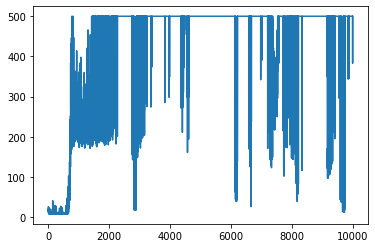

In [22]:
plt.plot(steps_total)
plt.show()

In [23]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 404.5409


In [24]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 404.5409
Average number of steps=reward in last 100 episodes: 498.83


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

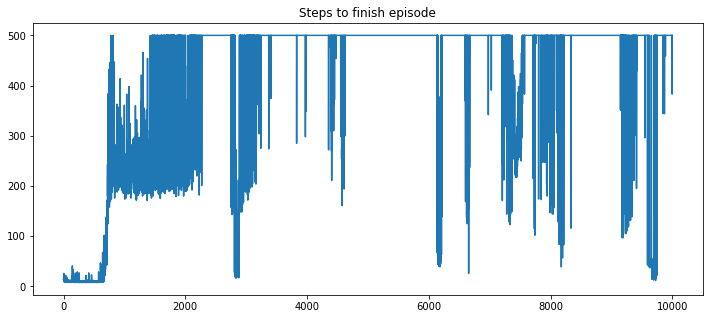

In [25]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()